In [1]:
import numpy as np
import pandas as pd

from PIL import Image
import glob
import cv2

import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.signal import convolve2d
from skimage.measure import label

# Data Importation

In [2]:
shape_selected = (720,1280)
def imp(directory):
    '''
    Returns, from a directory, a list of images + their filename and a dataframe containing the groundtruths
    
    parameters: 
    directory : a folder where the images are
    '''
    image_list = []
    filenames = []
    for filename in glob.glob(directory + '/*.jpg'):
        im = cv2.imread(filename)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        shape = np.shape(im)[0:2]
        # We only keep the images of the size defined above
        if shape == shape_selected:
            filenames.append(filename[3:])
            image_list.append([im,filename[3:]])
    
    df = pd.DataFrame()
    for filename in glob.glob(directory + '/*.txt'):
        data = pd.read_table(filename, header = None, sep = '\t')
        if data[0].values[0] in filenames:
            df = pd.concat([df, data])
    df.columns = ['file','a', 'b', 'c', 'd', 'target']
    df = df.set_index('file')
    return image_list, df

images_br, data_br = imp('br')
images_us, data_us = imp('us')

# Visualization Functions

In [3]:
"""Ground Truth"""
def showGT(images, data, i):
    '''
    This function allows to plot the groundtruth of an image
    '''
    im = images[i][0]
    filename = images[i][1]

    plt.figure(figsize=(12,6))
    plt.imshow(im)
    a, b, c, d = data[data.index == filename].values.tolist()[0][:-1]
    plt.plot([a, a + c, a + c, a, a], [b, b, b + d, b + d, b], 'r')
    
    
"""Candidates"""
def showRectangles(boxes, img):
    '''
    This function is quite similar, it plots the rectangles obtained by our algorithms
    '''
    fig,ax = plt.subplots(1, figsize = (12,6))
    ax.imshow(img)
    for b in boxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((b[0], b[1]), b[2], b[3], linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

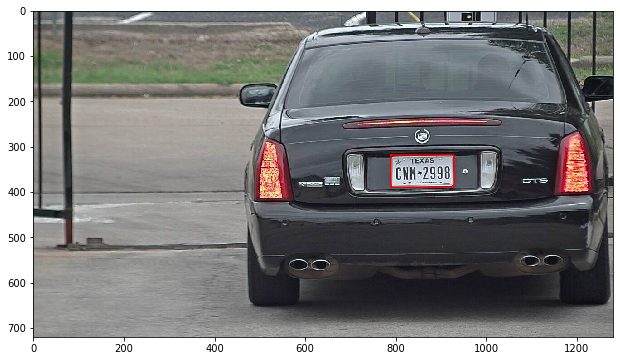

In [4]:
showGT(images_us, data_us, 113)

# Algorithms

## Morphology-based license plate detection from complex scenes

In [5]:
def preprocessing(img):
    '''
    Performs the equalization of histogram for an image
    
    parameters:
    img, an image
    ''' 
    equ = cv2.equalizeHist(img)
    return equ

def smoothing(img,kernel_sizes):
    '''
    Performs the smoothing of an image
    
    parameters:
    img, an image
    kernel_sizes, the size of the structure element used to smooth
    '''
    n,m = kernel_sizes
    S = 1/n/m*np.ones((n,m))
    smoothed_img = convolve2d(img,S,'same')
    return smoothed_img

def opening_img(img,kernel_sizes):
    '''
    Performs the opening of an image
    
    parameters:
    img, an image
    kernel_sizes, the size of the structure element used to open
    '''
    kernel = np.ones(kernel_sizes)
    opened_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opened_img

def closing_img(img,kernel_sizes):
    '''
    Performs the closing of an image
    
    parameters:
    img, an image
    kernel_sizes, the size of the structure element used to close
    '''
    kernel = np.ones(kernel_sizes)
    closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return closed_img


''' The following functions have the same purpose as the 2 functions above.'''
''' We tried to implement them on our own but we got the same results and our functions were slower.'''
# def dilation(img,kernel_sizes):
#     sizex,sizey = np.shape(img)
#     dilated_img = np.zeros((sizex,sizey))
#     n,m = kernel_sizes
#     winh = n//2
#     winw = m//2
#     for i in range(sizex):
#         for j in range(sizey):
#             window = img[max(0,i-winh):min(sizex,i+winh+1),max(0,j-winw):min(sizey,j+winw+1)]
#             dilated_img[i,j] = np.max(window)
#     return dilated_img

# def erosion(img,kernel_sizes):
#     sizex,sizey = np.shape(img)
#     eroded_img = np.zeros((sizex,sizey))
#     n,m = kernel_sizes
#     winh = n//2
#     winw = m//2
#     for i in range(sizex):
#         for j in range(sizey):
#             window = img[max(0,i-winh):min(sizex,i+winh+1),max(0,j-winw):min(sizey,j+winw+1)]
#             eroded_img[i,j] = np.min(window)
#     return eroded_img

# def opening_img(img,kernel_sizes):
#     eroded_img = erosion(img,kernel_sizes)
#     opened_img = dilation(eroded_img,kernel_sizes)
#     return opened_img

# def closing_img(img,kernel_sizes):
#     dilated_img = dilation(img,kernel_sizes)
#     closed_img = erosion(dilated_img,kernel_sizes)
#     return closed_img

def diff(img1,img2):
    '''
    Performs the differecing between two images
    
    parameters:
    img1, the first image
    img2, the second image
    '''
    diff_img = np.abs(img1-img2)
    return diff_img

def thresholding_img(img, thresh):
    '''
    Performs the thresholding of an image
    
    parameters:
    img, an image
    thresh, the threshold to use for thresholding
    '''
    threshold = thresh*np.max(img)
    n,m = np.shape(img)
    thresh_img = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if img[i,j]>threshold:
                thresh_img[i,j] = 255
    return thresh_img

def labeling(img):
    '''
    Label the img by connecting components
    
    parameters:
    img, an image
    '''
    label_img = label(img)
    return label_img

In [6]:
def extraction_plates(img, thresh = 0.3):
    '''
    This function extract the license plates candidates using all the
    morphological functions above
    
    parameters:
    img, an image
    thresh, the threshold to use for thresholding
    '''
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    equ = preprocessing(grey_img)
    
    smoothed_img = smoothing(equ,(7,7))
    
    closed_img = closing_img(smoothed_img,(18,1))
    
    opened_img = opening_img(smoothed_img,(18,1))
    
    differenced_img = diff(closed_img, opened_img)
    
    diff_closed_img = closing_img(differenced_img,(1,18))
    
    thresh_img = thresholding_img(diff_closed_img,thresh)
    
    labels = labeling(thresh_img)
    return labels

def find_bests(labels):
    '''
    Select only the potential license plates using informations known
    about license plates
    
    parameters:
    labels, the labels obtained thanks to the previous question
    '''
    candidates = []
    for i in range(1,np.max(labels)+1):
        cand = np.argwhere(labels==i)
        if len(cand)>0:
            xs = cand[:,1]
            hs = cand[:,0]
            width = np.max(xs)-np.min(xs)
            height = np.max(hs)-np.min(hs)
            point = [np.min(xs), np.min(hs)]
            if height>25 and width>60:
                density = len(cand)/(width*height)
                if density > 0.25 and density<0.85:
                    if width/height>1 and width/height<3.5:
                        candidates.append([point[0],point[1],width,height])
    return candidates

def morphologicad_based_detection(img, thresh = 0.3):
    '''
    This function realises the entire morphological based detection
    
    parameters:
    img, an image
    thresh, the threshold to use for thresholding
    '''
    labels = extraction_plates(img, thresh)
    candidates = find_bests(labels)
    return candidates

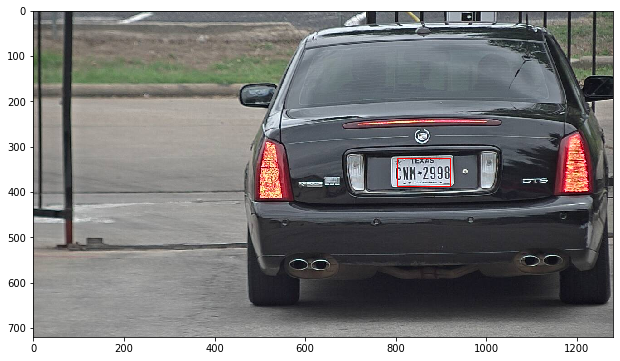

In [7]:
img = images_us[113][0]
candidates = morphologicad_based_detection(img)

showRectangles(candidates, img)
    

## Blob-based license plate detection 

In [8]:
def blob_based_detection(img):    
    '''
    This function detects license plates candidates in an image
    
    parameter: img, an image
    '''
    #Maximally stable extremal regions (MSER)
    regions, bboxes = make_blobs(img)
    
    # Region properties filtering for numbers
    filtered_boxes = regionpropertiesfiltering(bboxes)
    
    # Merge of overlapping boxes
    merged_boxes = merge_boxes(filtered_boxes, 5)
    
    # Region properties filtering for 
    candidates = regionpropertiesfiltering2(merged_boxes)
    
    return candidates


""" *** Functions used: *** """

def make_blobs(img, show_blobs = False):   
    '''
    This function detects blobs regions with a maximally stable extremal regions algorithm (MSER)
    
    parameters: 
    img, an image
    show_blobs (bool), to indicate if the results should be displayed on screen
    
    outputs:
    regions, the blobs
    bboxes, the corresponding bounding boxes
    '''
    
    #conversion to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

    #Maximally stable extremal regions (MSER)
    #Create MSER object
    mser = cv2.MSER_create()

    #detect regions in gray scale image
    regions, bboxes = mser.detectRegions(gray_img)
    
    if show_blobs:
        hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

        vis = img.copy()
        cv2.polylines(vis, hulls, 1, (0, 255, 0))

        plt.figure(figsize = (10,10))
        plt.imshow(vis)

    return regions, bboxes



"""Filtering"""

def regionpropertiesfiltering(bboxes):
    '''
    This function filters bounding boxes depending on their aspect ratio (heigh to width)
    
    parameter: 
    bboxes, a list of bounding boxes
    '''
    
    #geometric identifier: Aspect ratio : height to width ratio
    filtered_boxes = []
    for bbox in bboxes:
        ratio = aspect_ratio(bbox)
        if (aspect_ratio(bbox) > 1.3) and (aspect_ratio(bbox) < 4.5):
            filtered_boxes.append(bbox)
    return filtered_boxes

def regionpropertiesfiltering2(bboxes):
    '''
    This function filters bounding boxes depending on their aspect ratio
    
    parameter: 
    bboxes, a list of bounding boxes
    '''
    
    filtered_boxes = []
    for bbox in bboxes:
        ratio = aspect_ratio(bbox)
        if (aspect_ratio(bbox) > 0.15) and (aspect_ratio(bbox) < 0.5):
            filtered_boxes.append(bbox)
    return filtered_boxes
 
def aspect_ratio(bbox):
    '''This function computes the aspect ratio of a bounding box'''
    return bbox[3]/bbox[2]



"""Merging overlapping boxes"""

def merge_boxes(boxes, n_epochs):
    '''This function merges boxes that are close enough to each other
    
    parameters: 
    boxes, a list of bounding boxes
    n_epochs, the number of times the algorithm goes through the list and updates it
    '''
    
    for e in range(n_epochs):
        caracteristics = []
        for i,box in enumerate(boxes):
            x, y, dx, dy = box
            x1 = x
            x2 = x + dx
            y1 = y
            y2 = y + dy
            x_len = (dx)/2
            center_x = x + dx/2
            center_y = y + dy/2
            caracteristics.append([[x1, x2, y1, y2], [center_x, center_y], x_len])

        groups = [[0]]
        for i in range(1, len(boxes)):
            noGroup = True
            group_idx = 0
            while noGroup and (group_idx < len(groups)):
                for rect_idx in groups[-(1+group_idx)]:
                    if closeEnough(caracteristics[i], caracteristics[rect_idx], np.shape(img)[0]):
                        groups[-(1+group_idx)].append(i)
                        noGroup = False
                        break
                group_idx+=1
            if noGroup:
                groups.append([i])

        boxes = []
        for group in groups:
            boxes.append(mergeGroup(group, caracteristics))
        
    return boxes

def closeEnough(carac1, carac2, img_height):
    '''returns True if the two boxes with the caracteristics carac1 and carac2 are close enough'''
    
    # We favour boxes that are close to each other along axis x
    if np.abs((carac1[1][1] - carac2[1][1])) < 0.02 * img_height:
        if np.abs((carac1[1][0] - carac2[1][0])) < 1.3 * (carac1[2]+carac2[2]):
            return True
    return False
    
    
def mergeGroup(group, caracteristics):
    '''merges bounding boxes that are in the list group into a single bounding box'''
    
    x1 = 100000
    x2 = 0
    y1 = 100000
    y2 = 0
    for rect_idx in group:
        rect = caracteristics[rect_idx]
        if rect[0][0] < x1:
            x1 = rect[0][0]
        if rect[0][1] > x2:
            x2 = rect[0][1]
        if rect[0][2] < y1:
            y1 = rect[0][2]
        if rect[0][3] > y2:
            y2 = rect[0][3]
    return [x1, y1, x2-x1, y2-y1]


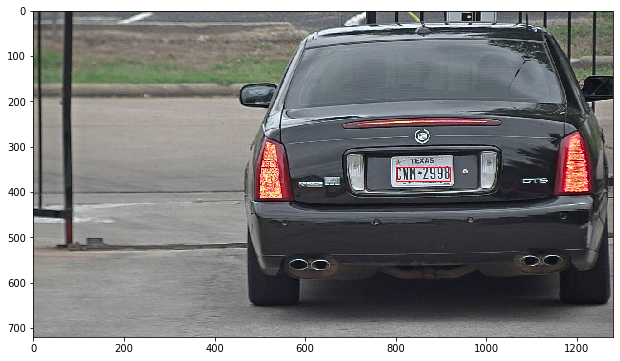

In [9]:
img = images_us[113][0]
candidates = blob_based_detection(img)

showRectangles(candidates, img)

## Edges-based license plate detection

In [10]:
def S(m, n, func, img):
    '''
    Return the integral image on a m*n rectangle window for a given function
    
    parameters: 
    m and n the size of the window 
    func the function studied
    img an image
    '''
    S = 0
    for i in range(m+1):
        for j in range(n+1):
            S += func(img,i,j)
    return S

def SW(m, n, i, j, func, img):
    '''
    Return the integral image on a m*n rectangle window centered on pixel i,j for a given function
    
    parameters: 
    m and n the size of the window 
    i and j the coordinates of the center pixel
    func the function studied
    img an image
    '''
    l1, l2 = img.shape[0], img.shape[1]
    i1 = max(0, int(i - m/2))
    j1 = max(0, int(j - n/2))
    i2 = min(int(i + m/2), l1-1)
    j2 = min(int(j + m/2), l2-1)
    #if i1 < 0 and j1 < 0 :
    #    SW = S(i2, j2, func, img)
    #elif i1 < 0 and 0 <= j2 <= l2:
    #    SW = S(i2, j2, func, img) - S(i2, j1-1, func, img)  
    #elif i1 < 0 and j2 > l2:
    #    SW = S(i2, l2-1, func, img) - S(i2, j1-1, func, img)
    #elif 0 <= i1 <= l1 and j2 > l2:
    #    SW = S(i2, l2-1, func, img) - S(i2, j1-1, func, img)
    SW = S(i2, j2, func, img) - S(i1-1, j2, func, img) - S(i2, j1-1, func, img) + S(i1-1, j1-1, func, img)
    return SW

def luminance(img,i,j):
    '''
    Return the luminance of an image at pixel i,j
    
    parameters: 
    img a grey image
    i and j the coordinates of the pixel
    '''    
    return img[i,j]

def square_luminance(img,i,j):
    '''
    Return the squared luminance of an image at pixel i,j
    
    parameters: 
    img a grey image
    i and j the coordinates of the pixel
    '''
    return img[i,j]**2
    
def mean_lum(m,n,i,j,img):
    '''
    Return the mean luminance of an image on a m*n rectangle window centered on pixel i,j
    
    parameters: 
    m and n the size of the window 
    i and j the coordinates of the pixel
    img a grey image
    '''    
    return SW(m, n, i, j, luminance, img)/(m*n)

def std_lum(m,n,i,j,img):
    '''
    Return the standard deviation of the luminance of an image on a m*n rectangle window centered on pixel i,j
    
    parameters: 
    m and n the size of the window 
    i and j the coordinates of the pixel
    img a grey image
    '''       
    return (SW(m, n, i, j, square_luminance, img)/(m*n)-mean_lum(m,n,i,j,img)**2)

def enhancement_long(img, m=40, n=80):
    '''
    Return the enhanced version of an image
    
    parameters: 
    img a gray image
    m and m the size of the window used
    '''
    l1, l2 = img.shape[0], img.shape[1]
    en_img = np.zeros(img.shape)
    for i in range(l1):
        for j in range(l2):
            std = std_lum(m,n,i,j,img)
            mean = mean_lum(m,n,i,j,img)
            if 0 <= std < 20:
                f = 3 / ((2/400)*(std-20)**2 + 1)
            elif 20 <= std < 60:
                f = 3 / ((2/1600)*(std-20)**2 + 1)
            else:
                f = 1
            en_img[i][j] = f*(img[i][j] - mean) + mean
    return en_img

def enhancement(img, m=40, n=80):
    '''
    Return the enhanced version of an image. Accelerated function through interpolation. 
    
    parameters: 
    img a gray image
    m and m the size of the window used
    '''
    l1, l2 = img.shape[0], img.shape[1]
    en_img = np.zeros(img.shape)
    std, mean = np.zeros(img.shape), np.zeros(img.shape)
    nb1, nb2 = l1/m, l2/n
    for a in range(int(nb1+1)):
        for b in range(int(nb2+1)):
            x = max(0,a*m-1)
            y = max(0,b*n-1)
            std[x][y] = std_lum(m,n,x,y,img)
            mean[x][y] = mean_lum(m,n,x,y,img)
            if x < l1-1 and y < l2-1:
                for i in range(int(x+1),int(x+nb1)):
                    for j in range(int(y+1),int(y+nb2)):
                        cx = (j - y) / n
                        cy = (i - x) / m
                        mA, mB, mC, mD = mean[x][y], mean[x][int(y+nb2)], mean[int(x+nb1)][y], mean[int(x+nb1)][int(y+nb2)]
                        sA, sB, sC, sD = std[x][y], std[x][int(y+nb2)], std[int(x+nb1)][y], std[int(x+nb1)][int(y+nb2)]
                        mean[i][j] = (1-cy)*((1-cx)*mA + cx*mB) + cy*((1-cx)*mC + cx*mD)
                        std[i][j] = (1-cy)*((1-cx)*sA + cx*sB) + cy*((1-cx)*sC + cx*sD)
    for i in range(l1):
        for j in range(l2):       
            if 0 <= std[i][j] < 20:
                f = 3 / ((2/400)*(std[i][j]-20)**2 + 1)
            elif 20 <= std[i][j] < 60:
                f = 3 / ((2/1600)*(std[i][j]-20)**2 + 1)
            else:
                f = 1
            en_img[i][j] = f*(img[i][j] - mean[i][j]) + mean[i][j]      
    return en_img


def vertical_gradient(img):
    '''
    Return the vertical gradient values image of an image
    
    parameters: 
    img a gray image
    '''
    #Sobel kernel
    Kx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    gx = convolve2d(img, Kx, 'same')
    return gx

def vertical_edges(en):
    '''
    Return the vertical edges image of an image
    
    parameters: 
    en a gray image
    ''' 
    #vertical gradient
    grad = vertical_gradient(en)
    #non-maximum suppression
    mea = np.mean(np.abs(grad))
    thre = 4*mea
    l1, l2 = en.shape[0], en.shape[1]
    g_max = np.zeros((l1,l2))
    for i in range(l1):
        for j in range(l2):
            if (grad[i,j] >= thre):
                    g_max[i,j] = 1 #grad[i,j]
    return g_max

def background_noise(edges, tshort=20 , tlong=150):
    '''
    Return the vertical edges image without background noise and curve
    
    parameters: 
    edges a vertical edges image
    tshort the threshold for suppression of very short edges (noise)
    tlong the threshold for suppression of very long edges (background curve)
    '''    
    M, N = np.zeros(edges.shape), np.zeros(edges.shape)
    l1, l2 = edges.shape[0], edges.shape[1]
    res = edges
    for i in range(1, l1-2):
        for j in range(1, l2-2):
            if edges[i][j] == 1:
                if edges[i-1][j-1] + edges[i-1][j] + edges[i-1][j+1] + edges[i][j-1] >0:
                    M[i][j] = max(M[i-1][j-1],M[i-1][j],M[i-1][j+1],M[i][j-1]) + 1
                else:
                    M[i][j] = max(M[i-2][j-1],M[i-2][j],M[i-2][j+1],M[i-1][j-2],M[i-1][j+2],M[i][j-2]) + 1
    for i in range(l1-3,2,-1):
        for j in range(l2-3,2,-1):
            if edges[i][j] == 1:
                if edges[i+1][j-1] + edges[i+1][j] + edges[i+1][j+1] + edges[i][j+1] >0:
                    N[i][j] = max(N[i+1][j-1],N[i+1][j],N[i+1][j+1],N[i][j+1]) + 1
                else:
                    N[i][j] = max(N[i+2][j-1],N[i+2][j],N[i+2][j+1],N[i+1][j-2],N[i+1][j+2],N[i][j+2]) + 1
    for i in range(l1):
        for j in range(l2): 
            if edges[i][j] == 1:
                if (M[i][j] + N[i][j] > tlong) or (M[i][j] + N[i][j] < tshort):
                    res[i][j] = 0
    return res

def B_prim(res, xlen = 90, ylen = 160):
    '''
    Return, from a vertical edges image, a block image used for license plate area localization 
    
    parameters: 
    res a vertical edges image
    xlen and ylen the size of the shifted window for license plate area localization
    '''      
    nb1, nb2 = 18, 16
    l1, l2 = res.shape[0], res.shape[1]
    m, n = l1 / nb1, l2 / nb2
    B = np.zeros((int(m),int(n)), dtype=np.int32)
    for a in range(int(m)):
        for b in range(int(n)):
            s = 0
            x = max(0,a*nb1-1)
            y = max(0,b*nb2-1)
            for i in range(int(x+1),int(x+nb1)):
                for j in range(int(y+1),int(y+nb2)):
                    s+=res[i][j]
            B[a][b] = s
    wx = xlen/nb1
    wy = ylen/nb2
    window = np.ones((int(xlen/nb1), int(ylen/nb2)), dtype=np.int32)
    B_prim = convolve2d(B, window, 'same')
    return B_prim

def search_candidates(B_prim, t=0.8):
    '''
    Return, from a block image (see above), the coordinates of the center pixel of the 
    localized license plate area
    
    parameters: 
    B_prim a block image
    t a rate used to determine the threshold value for the candidates pixels
    '''
    b1, b2 = B_prim.shape[0], B_prim.shape[1]
    thre = t*B_prim.max()
    nb1, nb2 = 18, 16
    l = []
    bl = []
    for i in range(1, b1-1):
        for j in range(1, b2-1):
            if (B_prim[i][j] > thre and B_prim[i][j] >= B_prim[i-1][j] 
            and B_prim[i][j] >= B_prim[i][j-1] and B_prim[i][j] >= B_prim[i-1][j-1]
            and B_prim[i][j] >= B_prim[i+1][j] and B_prim[i][j] >= B_prim[i][j+1]
            and B_prim[i][j] >= B_prim[i+1][j+1] and B_prim[i][j] >= B_prim[i-1][j+1]
            and B_prim[i][j] >= B_prim[i+1][j-1]):
                l.append((i*nb1,j*nb2))
                bl.append(B_prim[i][j])
    indx = np.argmax(bl)
    return l[indx]

def loc_plate(res, xlen = 80, ylen = 150, t=0.8):
    '''
    Return, from a vertical edges image, the coordinates of the top-left pixel of the 
    localized license plate area, and the width and length of this area 
    (results homogeneous to the ground truth files)
    
    parameters: 
    res a vertical edges image
    xlen and ylen the size of the shifted window for license plate area localization
    t a rate used to determine the threshold value for the candidates pixels 
    '''
    Bp = B_prim(res, xlen, ylen)
    (mi, mj) = search_candidates(Bp, t) ## ??? lequel on prend
    ai, aj = mi - (xlen//2), mj - (ylen//2)
    return ai, aj, xlen, ylen

def plate_localization_edges(img, m=40, n=80, xlen = 80, ylen = 150, t=0.8):
    '''
    Complete pipeline
    Return, from a car image, the coordinates of the top-left pixel of the localized 
    license plate area, and the width and length of this area
    
    parameters: 
    res a vertical edges image
    xlen and ylen the size of the shifted window for license plate area localization
    t a rate used to determine the threshold value for the candidates pixels 
    '''
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #en = enhancement(grey_img, m, n)
    edges = vertical_edges(grey_img)
    res = background_noise(edges)
    a, b, c, d = loc_plate(res, xlen, ylen, t)
    return [[b, a, d, c]]

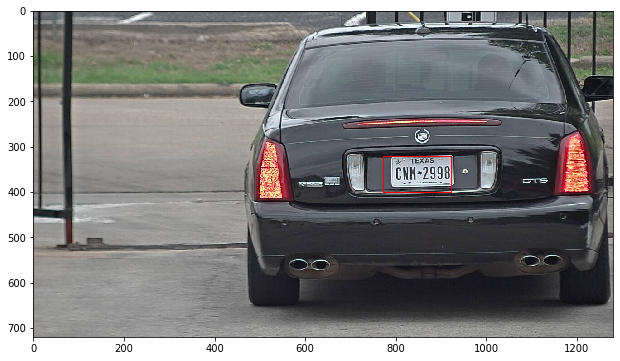

In [11]:
img = images_us[113][0]
candidates = plate_localization_edges(img)

showRectangles(candidates, img)

# Evaluation of the algorithms

## Test functions

In [12]:
_H = 720
_W = 1280
def intersection_over_union(gt, solution):
    """Caclulate the intersection over union metric
    
    parameters:
    gt, the groundtruth
    solution, the candidate(s) license plate(s)
    """
    score = 0
    black_sol = np.zeros((_H, _W))
    black_gt = np.zeros((_H, _W))
    for bb in solution:
        x, y = bb[0:2]
        dx, dy = bb[2:4]
        cv2.rectangle(black_sol, (x, y), (x+dx, y+dy), (255), -1)
    x, y = gt[0:2]
    dx, dy = gt[2:4]
    cv2.rectangle(black_gt, (x, y), (x+dx, y+dy), (255), -1)
    # intersection over union
    intersection = black_sol * black_gt
    intersection[intersection > 0.5] = 1
    union = black_sol + black_gt
    union[union > 0.5] = 1
    if union.any():
        score = intersection.sum()/union.sum()
    return score

IoU obtained :  0.7827338129496403


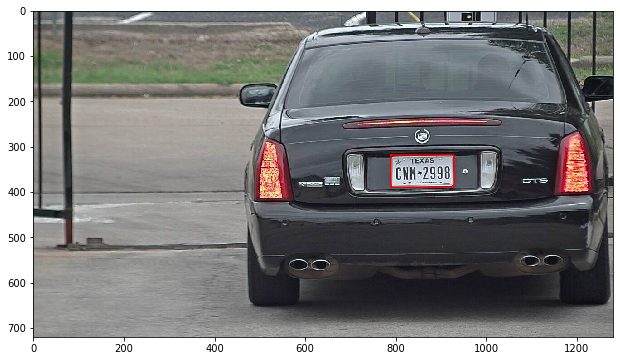

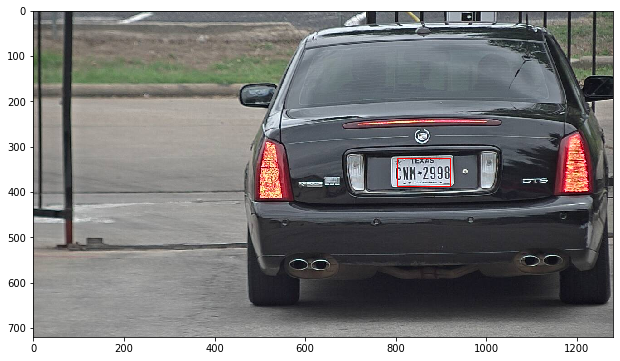

In [13]:
i = 113
img = images_us[i][0]
filename = images_us[i][1]

gt = data_us[data_us.index == filename].values.tolist()[0][:-1]

candidates = morphologicad_based_detection(img)
print('IoU obtained : ',intersection_over_union(gt, candidates))

showGT(images_us, data_us, i)
showRectangles(candidates, img)


IoU obtained :  0.394655704008222


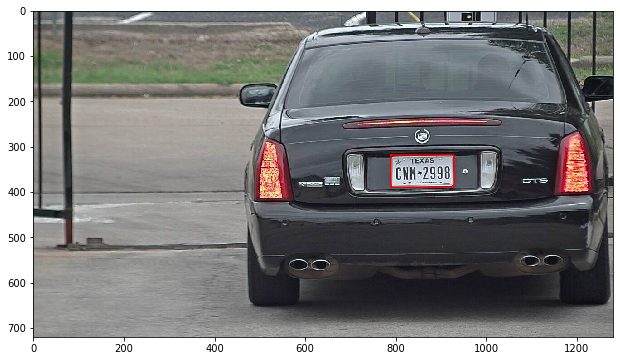

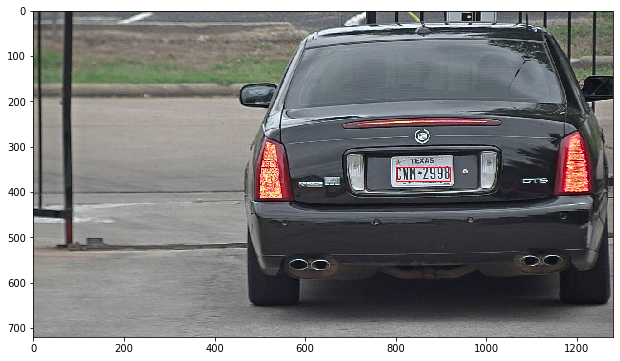

In [14]:
gt = data_us[data_us.index == filename].values.tolist()[0][:-1]

candidates = blob_based_detection(img)
print('IoU obtained : ',intersection_over_union(gt, candidates))

showGT(images_us, data_us, i)
showRectangles(candidates, img)


IoU obtained :  0.7271726307510814


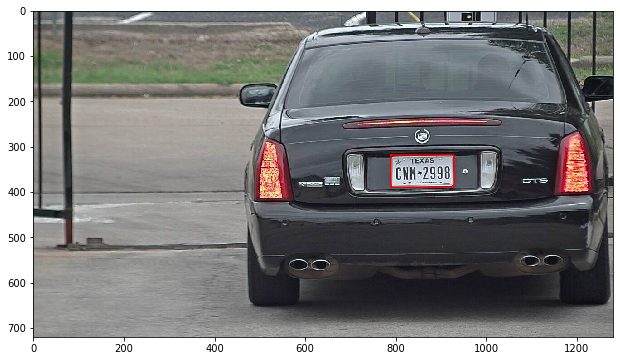

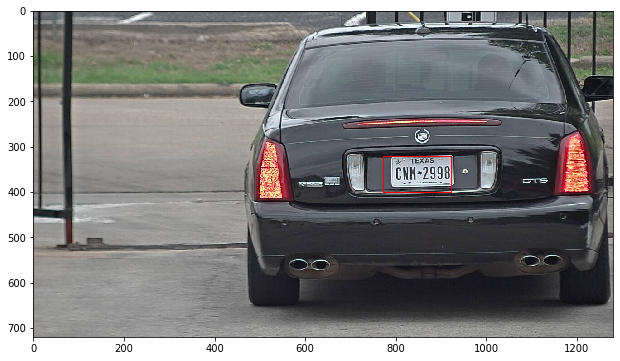

In [15]:
gt = data_us[data_us.index == filename].values.tolist()[0][:-1]

candidates = plate_localization_edges(img)
print('IoU obtained : ',intersection_over_union(gt, candidates))

showGT(images_us, data_us, i)
showRectangles(candidates, img)


## Comparison of the algorithms

In [16]:
'''
This function was made for performing the mAP but we got very bad results
So, we decided to compute the average IoU to compare our algorithms
'''

def evaluation(images, datas, thresholds, method = 'morpho'):
    '''
    This function compute the mAP score and the computation time for a method on all the dataset
    
    parameters:
    images, the images of the dataset
    datas, the dataframe containing the groundtruth
    thresholds, the thresholds used to define a True Positive
    method, the name of the algorithm we evaluate
    '''
    TPs = []
    FPs = []
    FNs = []
    precision = []
    recall = []
    F1 = []
    computation_time = []
    for thresh in thresholds:
        TP = 0
        FP = 0
        FN = 0
        times = []
        for i in range(len(images)):
            img = images[i][0]
            filename = images[i][1]
            gt = datas[datas.index == filename].values.tolist()[0][:-1]
            if method == 'morpho':
                t0 = time.time()
                candidates = morphologicad_based_detection(img, 0.3)
                times.append(time.time()-t0)
            elif method == 'blob':
                t0 = time.time()
                candidates = blob_based_detection(img)
                times.append(time.time()-t0)
            elif method == 'edge':
                t0 = time.time()
                candidates = plate_localization_edges(img)
                times.append(time.time()-t0)
            if len(candidates)==0:
                FN += 1
            else:
                score = intersection_over_union(gt, candidates)
                if score>=thresh:
                    TP += 1
                else:
                    FP += 1
        TPs.append(TP)
        FPs.append(FP)
        FNs.append(FN)
        if TP+FP == 0:
            precision.append(0)
        else:
            precision.append(TP/(TP+FP))
        if TP+FN == 0:
            recall.append(0)
        else:
            recall.append(TP/(TP+FN))
        if precision[-1]+recall[-1]==0:
            F1.append(0)
        else:
            F1.append(2*precision[-1]*recall[-1]/(precision[-1]+recall[-1]))
        computation_time.append(np.mean(times))
    return np.mean(F1), np.mean(computation_time)  


In [17]:
def evaluation2(images, datas, function):
    '''
    This function compute the average IoU and the computation time for a method on all the dataset
    
    parameters:
    images, the images of the dataset
    datas, the dataframe containing the groundtruth
    function, the name of the algorithm we evaluate
    '''
    scores = []
    times = []
    for i in range(len(images)):
        img = images[i][0]
        filename = images[i][1]
        gt = datas[datas.index == filename].values.tolist()[0][:-1]
        t0 = time.time()
        candidates = function(img)
        times.append(time.time()-t0)

        scores.append(intersection_over_union(gt, candidates))
    return np.mean(scores), np.mean(times)  


def compareAlgorithms(images, datas, algorithms):
    '''
    This function compare the algorithms thanks to the function above
    
    parameters:
    images, the images of the dataset
    datas, the dataframe containing the groundtruth
    algorithms, the algorithms we compare
    '''
    results = []
    for algo in algorithms:
        score, computation_time = evaluation2(images, datas, algo)
        print(algorithms[algo],":")
        print("Average IoU score:", round(score,3))
        print("Average computation time:", round(computation_time,3),"\n")
        results.append([score, computation_time])

    return results


In [18]:
algorithms = {morphologicad_based_detection: 'Morphological detection', blob_based_detection:'blob detection', plate_localization_edges:'Edge detection'}

compareAlgorithms(images_br, data_br, algorithms)

Morphological detection :
Average IoU score: 0.368
Average computation time: 0.654 

blob detection :
Average IoU score: 0.387
Average computation time: 0.084 

Edge detection :
Average IoU score: 0.093
Average computation time: 3.153 



[[0.36839928686529183, 0.6541162848472595],
 [0.38696717573261685, 0.08371119499206543],
 [0.09259023223760424, 3.153175449371338]]

In [19]:
compareAlgorithms(images_us, data_us, algorithms)

Morphological detection :
Average IoU score: 0.074
Average computation time: 0.838 

blob detection :
Average IoU score: 0.211
Average computation time: 0.135 

Edge detection :
Average IoU score: 0.217
Average computation time: 3.366 



[[0.07384719222032717, 0.8375164318084717],
 [0.21108076063146247, 0.13549309571584064],
 [0.21714818825663482, 3.366138949394226]]